In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd

tf.test.is_gpu_available()

2022-05-18 14:59:25.630707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 14:59:25.631301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 14:59:25.631610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 14:59:25.632221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 14:59:25.632596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

True

5403 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Def functions: One-Hot Encoding and Split Data (Dataframe)

In [11]:
def Get_ListOfLabels(df_InputLabels):
    df_Tags = df_InputLabels.str.split(expand=True)
    columns = len(df_Tags.columns)

    for i in range(columns):
        if i == 0:
            df_aux = pd.DataFrame(df_Tags[0])
        else:
            df_aux = df_aux.append(pd.DataFrame(df_Tags[i].rename(index=0)))

    LabelList = (df_aux.drop_duplicates().sort_values([0], ascending=[True]))[0].tolist()
    LabelList = list(filter(None, LabelList))
    return LabelList


def Get_LabelEncodedArray(df_InputLabels, LabelList):
    LabelArray = np.zeros((df_InputLabels.count(), len(LabelList)))
    TagsArray = df_InputLabels.str.split(expand=True).to_numpy()

    for i in range(TagsArray.shape[0]):
        for j in range(TagsArray.shape[1]):
            for k in range(len(LabelList)):
                if(TagsArray[i][j]== LabelList[k]):
                    LabelArray[i][k] = 1

    return LabelArray


def SplitData(df_Dataset, Ratio):

    df_TrainData = pd.DataFrame(df_Dataset).sample(round(Ratio * df_Dataset['filename'].count()))

    df_ValData = pd.DataFrame(df_Dataset)
    condition = df_ValData['filename'].isin(df_TrainData['filename'])
    df_ValData = df_ValData.drop(df_ValData[condition].index)

    return df_TrainData, df_ValData

### **Coding labels:** One-Hot Encoding

In [12]:
source_path = "../input/amazon-satellite/raw-data"
source_path_Labels = os.path.join(source_path, 'train_v2.csv')
source_path_Images = os.path.join(source_path, 'train-jpg')

df_Raw = pd.read_csv(source_path_Labels)
LabelList = Get_ListOfLabels(df_Raw.tags)

Get_LabelEncodedArray(df_Raw.tags, LabelList)
df_Dataset = pd.DataFrame(Get_LabelEncodedArray(df_Raw.tags, LabelList), columns=LabelList)
df_Dataset['filename'] = df_Raw.image_name.to_list()
df_Dataset['filename'] = df_Dataset['filename']+'.jpg'
df_Dataset = df_Dataset.loc[: , ['filename']+LabelList]

## Training and Validation Generators

Now that you know the images you are dealing with, it is time for you to code the generators that will fed these images to your Network. For this, complete the `train_val_generators` function below:

**Important Note:** The images have a resolution of 256x256 but the `flow_from_dataframe` method you will use allows you to set a target resolution. Lower resolution may yield much quicker training times without compromising the accuracy!

In [13]:
# Get Data Generators
def train_val_generators(DIRECTORY, df_Train, df_Validation):
    
  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values and set arguments to augment the images 
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # flow_from_dataframe method
  train_generator = train_datagen.flow_from_dataframe(dataframe=df_Train,
                                                      directory=DIRECTORY,
                                                      x_col=df_Train.columns[0],
                                                      y_col=df_Train.columns[1:len(df_Train.columns)],
                                                      batch_size=32, 
                                                      class_mode='raw',
                                                      target_size=(256, 256))

  # Instantiate the ImageDataGenerator class (set the rescale argument)
  # Validation data not augmented
  validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
    
  # flow_from_dataframe method
  validation_generator = validation_datagen.flow_from_dataframe(dataframe=df_Validation,
                                                                directory=DIRECTORY,
                                                                x_col=df_ValData.columns[0],
                                                                y_col=df_ValData.columns[1:len(df_ValData.columns)],
                                                                batch_size=32, 
                                                                class_mode='raw',
                                                                target_size=(256, 256))
  return train_generator, validation_generator

In [14]:
# Split Data
TrainToValidation_DataSize_Ratio = 0.6
df_TrainData, df_ValData = SplitData(df_Dataset, TrainToValidation_DataSize_Ratio)

# Test Generators
train_generator, validation_generator = train_val_generators(source_path_Images, df_TrainData, df_ValData)

Found 24287 validated image filenames.
Found 16192 validated image filenames.


## Model Definition
- Download InceptionV3 weights and define layers connected

In [15]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-05-18 15:00:45--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.128, 172.217.193.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   149MB/s    in 0.6s    

2022-05-18 15:00:46 (149 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [44]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
import tensorflow_addons as tfa

def create_model(NumOfClasses):
    
    #Load InceptionV3 Model
    local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    InceptionModel = InceptionV3(input_shape = (256, 256, 3), include_top = False, weights = local_weights_file)
    #Make all layers on InceptionV3 untrainable
    for layer in InceptionModel.layers:
        layer.trainable = False
    #Get Last Convolution Layer
    InceptionDesiredLayer = InceptionModel.get_layer('mixed10').output

    #Define Top Layers connected to InceptionV3
    x = tf.keras.layers.Flatten()(InceptionDesiredLayer)
    x = tf.keras.layers.Dense(2048, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(NumOfClasses, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=InceptionModel.input, outputs=x)

    model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['Precision',
                         'Recall', 
                         tfa.metrics.FBetaScore(beta=2.0, num_classes=NumOfClasses, average='micro', threshold=0.1),
                         tfa.metrics.F1Score(num_classes=NumOfClasses, average='micro', threshold=0.1),
                         'CategoricalAccuracy'
                        ]
               ) 
    return model

In [45]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_fbeta_score')>0.90):
      print("\nReached FBeta Score = 0.9. Stop Training!")
      self.model.stop_training = True

## Model Training

In [ ]:
# Get the untrained model
model = create_model(len(df_Dataset.columns)-1)

# Train the model
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=myCallback()
                   )

Epoch 1/15
759/759 [==============================] - 441s 574ms/step - loss: 0.2638 - precision: 0.6642 - recall: 0.7411 - fbeta_score: 0.7206 - f1_score: 0.5397 - categorical_accuracy: 0.1721 - val_loss: 0.1382 - val_precision: 0.8772 - val_recall: 0.8106 - val_fbeta_score: 0.8611 - val_f1_score: 0.7733 - val_categorical_accuracy: 0.0591
Epoch 2/15
743/759 [============================>.] - ETA: 8s - loss: 0.1560 - precision: 0.8709 - recall: 0.7764 - fbeta_score: 0.8347 - f1_score: 0.7247 - categorical_accuracy: 0.0731

## Save/Load Keras Model and History

In [ ]:
# Save
import pickle
from keras.models import load_model
with open("/kaggle/working/history.pkl", 'wb') as f:
    pickle.dump(history.history, f)
model.save("/kaggle/working/InceptionV3_Untrainable_V1.h5")


In [ ]:
# Load
import pickle
# model = keras.models.load_model("/kaggle/working/InceptionV3_Untrainable_V1.h5")
history = picke.load("/kaggle/working/history.pkl")

## Plot History

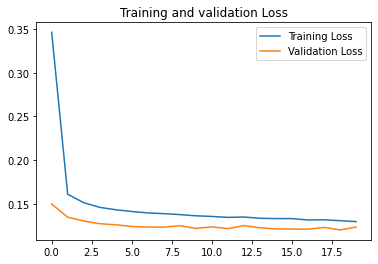

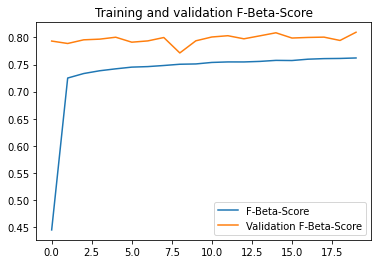

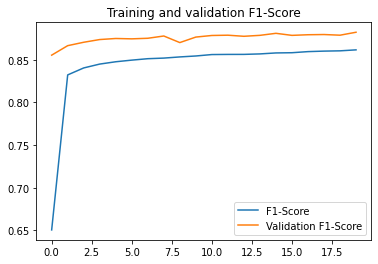

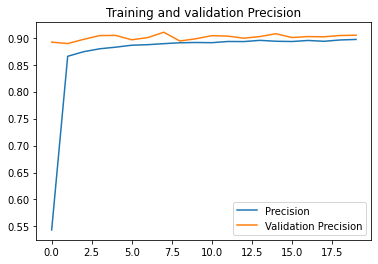

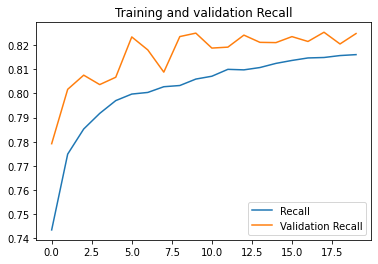

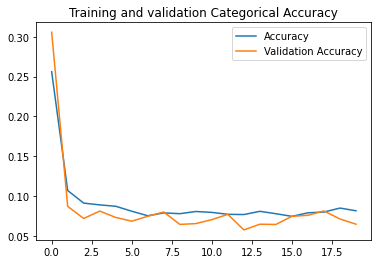

In [20]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']
val_loss=history.history['val_loss']

fbeta_score = history.history['fbeta_score']
val_fbeta_score = history.history['val_fbeta_score']

f1=history.history['f1_score']
val_f1 = history.history['val_f1_score']

recall = history.history['recall']
val_recall = history.history['val_recall']

precision = history.history['precision']
val_precision = history.history['val_precision']

acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title('Training and validation Loss')
plt.legend()
plt.show()

#------------------------------------------------
# Plot training and validation F1-Score per epoch
#------------------------------------------------
plt.plot(epochs, f1, label="F1-Score")
plt.plot(epochs, val_f1, label="Validation F1-Score")
plt.title('Training and validation F-Beta-Score')
plt.legend()
plt.show()

#------------------------------------------------
# Plot training and validation F-Beta-Score per epoch
#------------------------------------------------
plt.plot(epochs, fbeta_score, label="F-Beta-Score")
plt.plot(epochs, val_fbeta_score, label="Validation F-Beta-Score")
plt.title('Training and validation F1-Score')
plt.legend()
plt.show()

#------------------------------------------------
# Plot training and validation Precision per epoch
#------------------------------------------------
plt.plot(epochs, precision, label="Precision")
plt.plot(epochs, val_precision, label="Validation Precision")
plt.title('Training and validation Precision')
plt.legend()
plt.show()

#------------------------------------------------
# Plot training and validation Recall per epoch
#------------------------------------------------
plt.plot(epochs, recall, label="Recall")
plt.plot(epochs, val_recall, label="Validation Recall")
plt.title('Training and validation Recall')
plt.legend()
plt.show()

#------------------------------------------------
# Plot training and validation Recall per epoch
#------------------------------------------------
plt.plot(epochs, acc, label="Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.title('Training and validation Categorical Accuracy')
plt.legend()
plt.show()


print("")